# Partial Coherence in Wave Optics

This tutorial covers partial coherence modeling in Janssen, demonstrating both spatial and temporal coherence effects and their differentiable implementation.

## Overview

Real optical sources are never perfectly coherent:
- **LEDs** have broad spectra and extended emitting areas
- **Synchrotron sources** exhibit anisotropic spatial coherence
- **Lasers** suffer from mode noise and finite linewidth

Modeling these effects requires moving beyond the single complex field $E(x,y)$ to a statistical description of field correlations. This tutorial covers:

1. **Spatial coherence**: Extended sources and the van Cittert-Zernike theorem
2. **Temporal coherence**: Finite bandwidth and chromatic effects
3. **Coherent mode decomposition**: Efficient representation via Mercer's theorem
4. **Differentiability**: Gradient-based recovery of coherence parameters

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import optax

import janssen as jns
from janssen.coherence import (
    gaussian_coherence_kernel,
    jinc_coherence_kernel,
    coherence_width_from_source,
    gaussian_spectrum,
    lorentzian_spectrum,
    coherence_length,
    gaussian_schell_model_modes,
    hermite_gaussian_modes,
    effective_mode_count,
    propagate_coherent_modes,
    propagate_and_focus_modes,
    intensity_from_modes,
    led_source,
)
from janssen.models import collimated_gaussian
from janssen.prop import angular_spectrum_prop

# Configure matplotlib for publication figures
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['TeX Gyre Heros']
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'TeX Gyre Heros'
plt.rcParams['mathtext.it'] = 'TeX Gyre Heros:italic'
plt.rcParams['mathtext.bf'] = 'TeX Gyre Heros:bold'

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['figure.titlesize'] = 7

## Setup: Physical Parameters

In [2]:
# Physical parameters
wavelength = 633e-9  # HeNe laser, 633 nm
dx = 1e-6  # 1 um pixel size
grid_size = (256, 256)
beam_width = 100e-6  # 100 um beam width

# Derived quantities
physical_size = grid_size[0] * dx
extent_um = [-physical_size/2*1e6, physical_size/2*1e6,
             -physical_size/2*1e6, physical_size/2*1e6]

print(f"Wavelength: {wavelength*1e9:.0f} nm")
print(f"Grid: {grid_size[0]}x{grid_size[1]}, dx = {dx*1e6:.1f} um")
print(f"Physical extent: {physical_size*1e3:.2f} mm")

Wavelength: 633 nm
Grid: 256x256, dx = 1.0 um
Physical extent: 0.26 mm


---
# Part I: Spatial Coherence

## 1.1 The Mutual Intensity

For quasi-monochromatic light, the **mutual intensity** describes correlations between field values at two points:

$$J(\mathbf{r}_1, \mathbf{r}_2) = \langle E^*(\mathbf{r}_1) E(\mathbf{r}_2) \rangle$$

The **complex degree of coherence** normalizes this:

$$\mu(\mathbf{r}_1, \mathbf{r}_2) = \frac{J(\mathbf{r}_1, \mathbf{r}_2)}{\sqrt{I(\mathbf{r}_1) I(\mathbf{r}_2)}}$$

where:
- $|\mu| = 1$: Fully coherent
- $|\mu| = 0$: Completely incoherent
- $0 < |\mu| < 1$: Partially coherent

## 1.2 Van Cittert-Zernike Theorem

For an extended incoherent source, the mutual intensity in the far field is the Fourier transform of the source intensity:

$$J(\mathbf{r}_1, \mathbf{r}_2) \propto \mathcal{F}\{I_{\text{source}}\}(\mathbf{r}_1 - \mathbf{r}_2)$$

A **circular source** of diameter $D$ at distance $z$ produces a jinc-shaped coherence function:

$$\mu(\Delta r) = 2\frac{J_1(\pi D \Delta r / \lambda z)}{\pi D \Delta r / \lambda z}$$

with coherence width $\sigma_c \approx 0.44 \lambda z / D$.

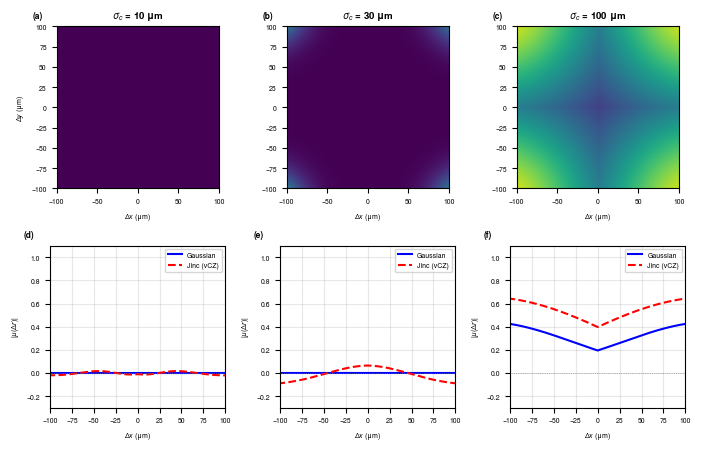


Van Cittert-Zernike relationship:
  sigma_c = 0.44 * lambda * z / D
  sigma_c = 10 um -> D = 2.79 mm (at z = 10 cm)
  sigma_c = 30 um -> D = 0.93 mm (at z = 10 cm)
  sigma_c = 100 um -> D = 0.28 mm (at z = 10 cm)


In [3]:
# Compare coherence kernels
coherence_widths = [10e-6, 30e-6, 100e-6]  # 10, 30, 100 um

fig, axes = plt.subplots(2, 3, figsize=(7, 4.5))

for idx, sigma_c in enumerate(coherence_widths):
    # Gaussian kernel
    kernel_gauss = gaussian_coherence_kernel(
        grid_size=grid_size, dx=dx, coherence_width=sigma_c
    )
    
    # Jinc kernel (van Cittert-Zernike)
    # Calculate source diameter that gives this coherence width
    prop_distance = 0.1  # 10 cm
    source_diameter = 0.44 * wavelength * prop_distance / sigma_c
    kernel_jinc = jinc_coherence_kernel(
        grid_size=grid_size, dx=dx,
        source_diameter=source_diameter,
        wavelength=wavelength,
        propagation_distance=prop_distance
    )
    
    # Plot 2D kernel
    ax = axes[0, idx]
    im = ax.imshow(kernel_gauss, cmap='viridis', extent=extent_um, vmin=0, vmax=1)
    ax.set_title(f'$\\sigma_c$ = {sigma_c*1e6:.0f} \u03bcm')
    ax.set_xlabel('$\\Delta x$ (\u03bcm)')
    if idx == 0:
        ax.set_ylabel('$\\Delta y$ (\u03bcm)')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    
    # Plot 1D slice comparison
    ax = axes[1, idx]
    center = grid_size[0] // 2
    x_um = (jnp.arange(grid_size[1]) - center) * dx * 1e6
    
    ax.plot(x_um, kernel_gauss[center, :], 'b-', linewidth=1.5, label='Gaussian')
    ax.plot(x_um, kernel_jinc[center, :], 'r--', linewidth=1.5, label='Jinc (vCZ)')
    ax.set_xlabel('$\\Delta x$ (\u03bcm)')
    ax.set_ylabel('$|\\mu(\\Delta r)|$')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-0.3, 1.1)
    ax.axhline(0, color='gray', linestyle=':', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=5)
    ax.grid(True, alpha=0.3)

axes[0, 0].text(-0.15, 1.05, '(a)', transform=axes[0, 0].transAxes, fontweight='bold')
axes[0, 1].text(-0.15, 1.05, '(b)', transform=axes[0, 1].transAxes, fontweight='bold')
axes[0, 2].text(-0.15, 1.05, '(c)', transform=axes[0, 2].transAxes, fontweight='bold')
axes[1, 0].text(-0.15, 1.05, '(d)', transform=axes[1, 0].transAxes, fontweight='bold')
axes[1, 1].text(-0.15, 1.05, '(e)', transform=axes[1, 1].transAxes, fontweight='bold')
axes[1, 2].text(-0.15, 1.05, '(f)', transform=axes[1, 2].transAxes, fontweight='bold')

plt.tight_layout()
plt.savefig('Figures/coherence_spatial_kernels.pdf', bbox_inches='tight')
plt.savefig('Figures/coherence_spatial_kernels.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVan Cittert-Zernike relationship:")
print(f"  sigma_c = 0.44 * lambda * z / D")
for sigma_c in coherence_widths:
    D = 0.44 * wavelength * prop_distance / sigma_c
    print(f"  sigma_c = {sigma_c*1e6:.0f} um -> D = {D*1e3:.2f} mm (at z = {prop_distance*100:.0f} cm)")

---
# Part II: Temporal Coherence

## 2.1 Spectral Width and Coherence Length

Temporal coherence arises from finite spectral bandwidth. The **coherence length** is:

$$L_c = \frac{\lambda^2}{\Delta\lambda}$$

This determines the path-length difference over which interference is observable.

| Source Type | Bandwidth | Coherence Length |
|-------------|-----------|------------------|
| HeNe laser | ~1 pm | ~400 m |
| LED | ~30 nm | ~13 \u03bcm |
| White light | ~300 nm | ~1 \u03bcm |

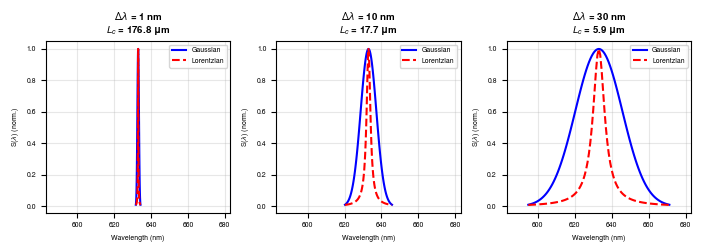

In [4]:
# Compare spectral distributions
center_wavelength = 633e-9
bandwidths_nm = [1, 10, 30]  # nm
num_wavelengths = 101

fig, axes = plt.subplots(1, 3, figsize=(7, 2.5))

for idx, bw_nm in enumerate(bandwidths_nm):
    bw = bw_nm * 1e-9
    
    # Gaussian spectrum
    wls_g, weights_g = gaussian_spectrum(
        center_wavelength=center_wavelength,
        bandwidth_fwhm=bw,
        num_wavelengths=num_wavelengths
    )
    
    # Lorentzian spectrum
    wls_l, weights_l = lorentzian_spectrum(
        center_wavelength=center_wavelength,
        bandwidth_fwhm=bw,
        num_wavelengths=num_wavelengths
    )
    
    # Coherence length
    L_c = coherence_length(center_wavelength, bw)
    
    ax = axes[idx]
    wls_nm = wls_g * 1e9
    ax.plot(wls_nm, weights_g / jnp.max(weights_g), 'b-', linewidth=1.5, label='Gaussian')
    ax.plot(wls_nm, weights_l / jnp.max(weights_l), 'r--', linewidth=1.5, label='Lorentzian')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('S($\\lambda$) (norm.)')
    ax.set_title(f'$\\Delta\\lambda$ = {bw_nm} nm\n$L_c$ = {L_c*1e6:.1f} \u03bcm')
    ax.legend(loc='upper right', fontsize=5)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(center_wavelength*1e9 - 50, center_wavelength*1e9 + 50)

plt.tight_layout()
plt.savefig('Figures/coherence_temporal_spectra.pdf', bbox_inches='tight')
plt.savefig('Figures/coherence_temporal_spectra.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Part III: Coherent Mode Decomposition

## 3.1 Mercer's Theorem

Any partially coherent field can be decomposed into orthogonal **coherent modes**:

$$J(\mathbf{r}_1, \mathbf{r}_2) = \sum_n \lambda_n \phi_n^*(\mathbf{r}_1) \phi_n(\mathbf{r}_2)$$

where:
- $\phi_n$ are orthonormal modes
- $\lambda_n$ are modal weights (eigenvalues)

The total intensity is an **incoherent sum**:

$$I(\mathbf{r}) = \sum_n \lambda_n |\phi_n(\mathbf{r})|^2$$

## 3.2 Gaussian Schell-Model Source

For a Gaussian Schell-model (GSM) source with beam width $\sigma_I$ and coherence width $\sigma_c$:
- The modes are **Hermite-Gaussian** functions
- The eigenvalues are analytically known:

$$\lambda_n = \left(\frac{1-a}{1+a}\right) \left(\frac{a}{1+a}\right)^n, \quad a = \frac{\sigma_c}{\sigma_I}$$

The **effective number of modes** (participation ratio) is:

$$M_{\text{eff}} = \frac{(\sum_n \lambda_n)^2}{\sum_n \lambda_n^2}$$

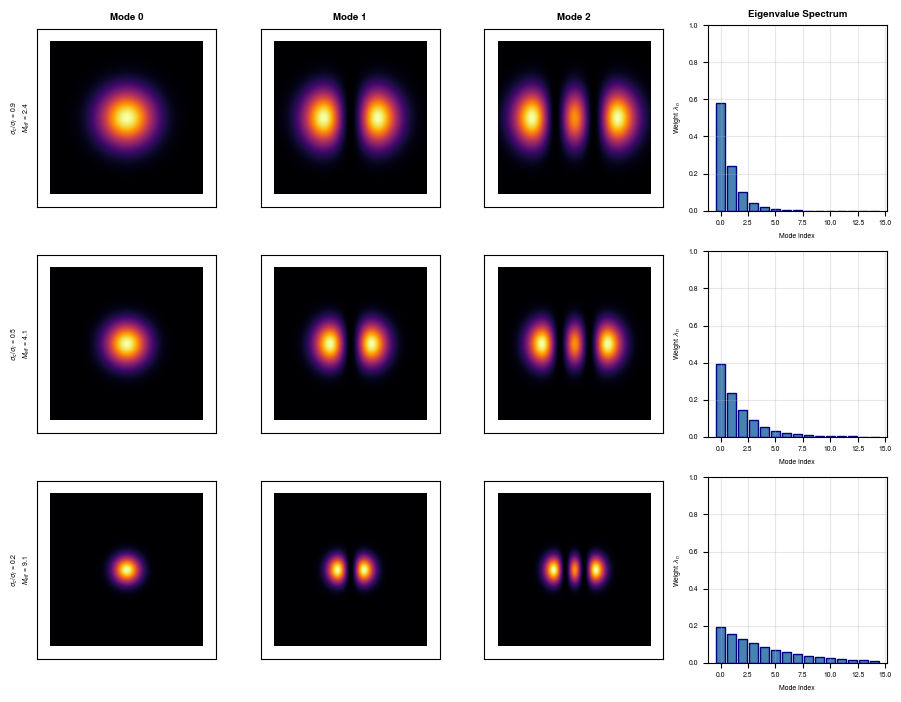


Effective mode count vs. coherence ratio:
  sigma_c/sigma_I = 0.9 -> M_eff = 2.44
  sigma_c/sigma_I = 0.5 -> M_eff = 4.12
  sigma_c/sigma_I = 0.2 -> M_eff = 9.09


In [5]:
# Generate Gaussian Schell-model modes for different coherence levels
coherence_ratios = [0.9, 0.5, 0.2]  # sigma_c / sigma_I
num_modes = 15

fig, axes = plt.subplots(3, 4, figsize=(9, 7))

for row, ratio in enumerate(coherence_ratios):
    sigma_c = ratio * beam_width
    
    # Generate GSM modes
    mode_set = gaussian_schell_model_modes(
        wavelength=wavelength,
        dx=dx,
        grid_size=grid_size,
        beam_width=beam_width,
        coherence_width=sigma_c,
        num_modes=num_modes
    )
    
    M_eff = effective_mode_count(mode_set)
    
    # Plot first 3 modes
    for col in range(3):
        ax = axes[row, col]
        mode_intensity = jnp.abs(mode_set.modes[col])**2
        im = ax.imshow(mode_intensity, cmap='inferno', extent=extent_um)
        ax.set_xlim(-150, 150)
        ax.set_ylim(-150, 150)
        if row == 0:
            ax.set_title(f'Mode {col}')
        if col == 0:
            ax.set_ylabel(f'$\\sigma_c/\\sigma_I$ = {ratio}\n$M_{{eff}}$ = {M_eff:.1f}')
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Plot eigenvalue spectrum
    ax = axes[row, 3]
    ax.bar(range(num_modes), mode_set.weights, color='steelblue', edgecolor='navy')
    ax.set_xlabel('Mode index')
    ax.set_ylabel('Weight $\\lambda_n$')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    if row == 0:
        ax.set_title('Eigenvalue Spectrum')

plt.tight_layout()
plt.savefig('Figures/coherence_gsm_modes.pdf', bbox_inches='tight')
plt.savefig('Figures/coherence_gsm_modes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEffective mode count vs. coherence ratio:")
for ratio in coherence_ratios:
    sigma_c = ratio * beam_width
    mode_set = gaussian_schell_model_modes(
        wavelength=wavelength, dx=dx, grid_size=grid_size,
        beam_width=beam_width, coherence_width=sigma_c, num_modes=num_modes
    )
    M_eff = effective_mode_count(mode_set)
    print(f"  sigma_c/sigma_I = {ratio:.1f} -> M_eff = {M_eff:.2f}")

## 3.3 Propagation of Partially Coherent Fields

Each coherent mode propagates independently. The final intensity is the incoherent sum of propagated mode intensities.

This is implemented efficiently using `jax.vmap` for parallel propagation of all modes.

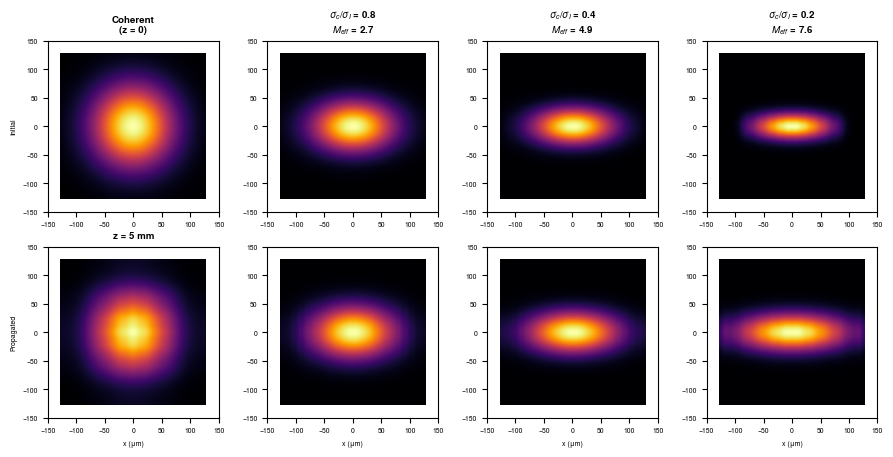

In [6]:
# Compare fully coherent vs partially coherent propagation
prop_distance = 5e-3  # 5 mm

# Fully coherent Gaussian beam
coherent_beam = collimated_gaussian(
    wavelength=wavelength, dx=dx, grid_size=grid_size,
    waist=beam_width, z_position=0.0
)
coherent_propagated = angular_spectrum_prop(coherent_beam, prop_distance)
I_coherent = jnp.abs(coherent_propagated.field)**2

# Partially coherent (GSM) beam with different coherence levels
coherence_levels = [0.8, 0.4, 0.2]

fig, axes = plt.subplots(2, 4, figsize=(9, 4.5))

# Top row: Initial intensity
ax = axes[0, 0]
I_initial = jnp.abs(coherent_beam.field)**2
ax.imshow(I_initial, cmap='inferno', extent=extent_um)
ax.set_title('Coherent\n(z = 0)')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_ylabel('Initial')

for idx, ratio in enumerate(coherence_levels):
    sigma_c = ratio * beam_width
    mode_set = gaussian_schell_model_modes(
        wavelength=wavelength, dx=dx, grid_size=grid_size,
        beam_width=beam_width, coherence_width=sigma_c, num_modes=10
    )
    I_initial_pc = intensity_from_modes(mode_set)
    
    ax = axes[0, idx+1]
    ax.imshow(I_initial_pc, cmap='inferno', extent=extent_um)
    M_eff = effective_mode_count(mode_set)
    ax.set_title(f'$\\sigma_c/\\sigma_I$ = {ratio}\n$M_{{eff}}$ = {M_eff:.1f}')
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)

# Bottom row: After propagation
ax = axes[1, 0]
ax.imshow(I_coherent, cmap='inferno', extent=extent_um)
ax.set_title(f'z = {prop_distance*1e3:.0f} mm')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_ylabel('Propagated')
ax.set_xlabel('x (μm)')

for idx, ratio in enumerate(coherence_levels):
    sigma_c = ratio * beam_width
    mode_set = gaussian_schell_model_modes(
        wavelength=wavelength, dx=dx, grid_size=grid_size,
        beam_width=beam_width, coherence_width=sigma_c, num_modes=10
    )
    
    # Propagate modes
    mode_set_prop = propagate_coherent_modes(mode_set, prop_distance)
    I_prop = intensity_from_modes(mode_set_prop)
    
    ax = axes[1, idx+1]
    ax.imshow(I_prop, cmap='inferno', extent=extent_um)
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    ax.set_xlabel('x (μm)')

plt.tight_layout()
plt.savefig('Figures/coherence_propagation_comparison.pdf', bbox_inches='tight')
plt.savefig('Figures/coherence_propagation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Part IV: Differentiable Partial Coherence

## 4.1 Why Differentiability Matters

Because Janssen implements coherent mode propagation using JAX, we can compute gradients with respect to coherence parameters. This enables:

1. **Coherence recovery**: Estimate source coherence from measured intensity patterns
2. **Joint optimization**: Recover both object and coherence in ptychography
3. **Sensitivity analysis**: How do results depend on coherence assumptions?

## 4.2 Example: Recovering Coherence Width from Propagated Intensity

Given a measured intensity pattern after propagation, can we recover the source coherence width?

In [7]:
# Define forward model: coherence width -> propagated intensity
prop_distance_opt = 5e-3  # 5 mm
num_modes_opt = 10

def forward_model(coherence_width):
    """Compute propagated intensity for given coherence width."""
    mode_set = gaussian_schell_model_modes(
        wavelength=wavelength,
        dx=dx,
        grid_size=grid_size,
        beam_width=beam_width,
        coherence_width=coherence_width,
        num_modes=num_modes_opt
    )
    mode_set_prop = propagate_coherent_modes(mode_set, prop_distance_opt)
    intensity = intensity_from_modes(mode_set_prop)
    return intensity

# Generate "ground truth" target with known coherence
true_coherence_width = 40e-6  # 40 um
I_target = forward_model(true_coherence_width)

print(f"True coherence width: {true_coherence_width*1e6:.0f} um")
print(f"Propagation distance: {prop_distance_opt*1e3:.0f} mm")

True coherence width: 40 um
Propagation distance: 5 mm


In [8]:
# Define loss function and compute gradient
def loss_fn(coherence_width):
    """MSE between predicted and target intensity."""
    I_pred = forward_model(coherence_width)
    return jnp.mean((I_pred - I_target)**2)

# Compute gradient with JAX
grad_loss = jax.grad(loss_fn)

# Test at a few points
test_widths = [20e-6, 40e-6, 60e-6, 80e-6]
print("\nLoss and gradient at different coherence widths:")
print(f"{'sigma_c (um)':<15} {'Loss':<15} {'dL/d(sigma_c)':<15}")
print("-" * 45)
for w in test_widths:
    loss = float(loss_fn(w))
    grad = float(grad_loss(w))
    print(f"{w*1e6:<15.0f} {loss:<15.6f} {grad:<15.6f}")


Loss and gradient at different coherence widths:
sigma_c (um)    Loss            dL/d(sigma_c)  
---------------------------------------------
20              0.000000        -0.000003      
40              0.000000        -0.000000      
60              0.000000        0.000001       
80              0.000000        0.000001       


In [9]:
# Gradient-based optimization to recover coherence width
initial_guess = 80e-6  # Start with wrong value (80 um instead of 40 um)

optimizer = optax.adam(learning_rate=2e-6)
params = jnp.array(initial_guess)
opt_state = optimizer.init(params)

n_iterations = 100
coherence_history = [float(params)]
loss_history = [float(loss_fn(params))]

print(f"Recovering coherence width from propagated intensity...")
print(f"True value: {true_coherence_width*1e6:.0f} um")
print(f"Initial guess: {initial_guess*1e6:.0f} um")
print(f"\nOptimization progress:")

for i in range(n_iterations):
    grad = grad_loss(params)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Ensure params stay positive
    params = jnp.maximum(params, 1e-6)
    
    coherence_history.append(float(params))
    loss_history.append(float(loss_fn(params)))
    
    if (i + 1) % 20 == 0:
        print(f"  Iter {i+1:3d}: sigma_c = {params*1e6:.2f} um, loss = {loss_history[-1]:.2e}")

print(f"\nFinal estimate: {params*1e6:.2f} um")
print(f"True value: {true_coherence_width*1e6:.0f} um")
print(f"Error: {abs(params - true_coherence_width)*1e6:.2f} um ({abs(params - true_coherence_width)/true_coherence_width*100:.1f}%)")

Recovering coherence width from propagated intensity...
True value: 40 um
Initial guess: 80 um

Optimization progress:
  Iter  20: sigma_c = 42.60 um, loss = 2.20e-13
  Iter  40: sigma_c = 37.73 um, loss = 1.76e-13
  Iter  60: sigma_c = 41.10 um, loss = 4.04e-14
  Iter  80: sigma_c = 39.63 um, loss = 4.64e-15
  Iter 100: sigma_c = 40.09 um, loss = 2.86e-16

Final estimate: 40.09 um
True value: 40 um
Error: 0.09 um (0.2%)


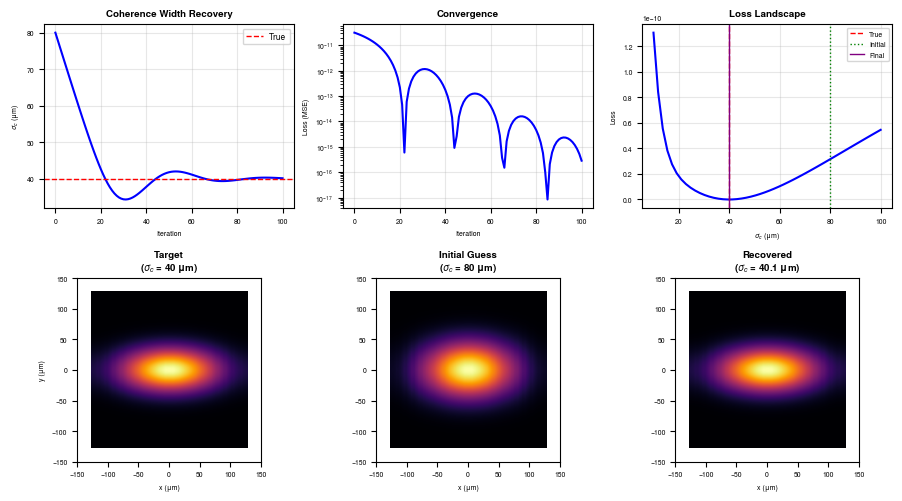

In [10]:
# Plot optimization results
fig, axes = plt.subplots(2, 3, figsize=(9, 5))

# Top row: Convergence
ax = axes[0, 0]
ax.plot([w*1e6 for w in coherence_history], 'b-', linewidth=1.5)
ax.axhline(true_coherence_width*1e6, color='r', linestyle='--', linewidth=1, label='True')
ax.set_xlabel('Iteration')
ax.set_ylabel('$\\sigma_c$ (\u03bcm)')
ax.set_title('Coherence Width Recovery')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.semilogy(loss_history, 'b-', linewidth=1.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Convergence')
ax.grid(True, alpha=0.3)

# Loss landscape
ax = axes[0, 2]
sigma_range = jnp.linspace(10e-6, 100e-6, 50)
losses = [float(loss_fn(s)) for s in sigma_range]
ax.plot(sigma_range*1e6, losses, 'b-', linewidth=1.5)
ax.axvline(true_coherence_width*1e6, color='r', linestyle='--', linewidth=1, label='True')
ax.axvline(initial_guess*1e6, color='g', linestyle=':', linewidth=1, label='Initial')
ax.axvline(params*1e6, color='purple', linestyle='-', linewidth=1, label='Final')
ax.set_xlabel('$\\sigma_c$ (\u03bcm)')
ax.set_ylabel('Loss')
ax.set_title('Loss Landscape')
ax.legend(loc='upper right', fontsize=5)
ax.grid(True, alpha=0.3)

# Bottom row: Intensity comparisons
I_initial = forward_model(initial_guess)
I_final = forward_model(params)

ax = axes[1, 0]
ax.imshow(I_target, cmap='inferno', extent=extent_um)
ax.set_title(f'Target\n($\\sigma_c$ = {true_coherence_width*1e6:.0f} \u03bcm)')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_xlabel('x (\u03bcm)')
ax.set_ylabel('y (\u03bcm)')

ax = axes[1, 1]
ax.imshow(I_initial, cmap='inferno', extent=extent_um)
ax.set_title(f'Initial Guess\n($\\sigma_c$ = {initial_guess*1e6:.0f} \u03bcm)')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_xlabel('x (\u03bcm)')

ax = axes[1, 2]
ax.imshow(I_final, cmap='inferno', extent=extent_um)
ax.set_title(f'Recovered\n($\\sigma_c$ = {params*1e6:.1f} \u03bcm)')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.set_xlabel('x (\u03bcm)')

plt.tight_layout()
plt.savefig('Figures/coherence_optimization.pdf', bbox_inches='tight')
plt.savefig('Figures/coherence_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.3 Gradient Visualization

We can visualize how the propagated intensity depends on coherence width by computing the spatial gradient map $\partial I(\mathbf{r}) / \partial \sigma_c$.

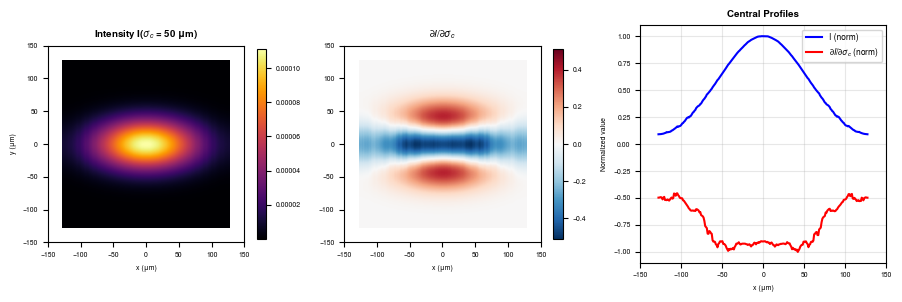

In [11]:
# Compute gradient of intensity with respect to coherence width
def intensity_at_coherence(coherence_width):
    return forward_model(coherence_width)

# Use finite difference for spatial gradient map
eps = 1e-7
sigma_test = 50e-6
I_plus = intensity_at_coherence(sigma_test + eps)
I_minus = intensity_at_coherence(sigma_test - eps)
dI_dsigma = (I_plus - I_minus) / (2 * eps)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# Intensity
ax = axes[0]
I_test = intensity_at_coherence(sigma_test)
im = ax.imshow(I_test, cmap='inferno', extent=extent_um)
ax.set_title(f'Intensity I($\\sigma_c$ = {sigma_test*1e6:.0f} \u03bcm)')
ax.set_xlabel('x (\u03bcm)')
ax.set_ylabel('y (\u03bcm)')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
plt.colorbar(im, ax=ax, shrink=0.8)

# Gradient map
ax = axes[1]
vmax = jnp.max(jnp.abs(dI_dsigma))
im = ax.imshow(dI_dsigma, cmap='RdBu_r', extent=extent_um, vmin=-vmax, vmax=vmax)
ax.set_title('$\\partial I / \\partial \\sigma_c$')
ax.set_xlabel('x (\u03bcm)')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
plt.colorbar(im, ax=ax, shrink=0.8)

# 1D profiles
ax = axes[2]
center = grid_size[0] // 2
x_um = (jnp.arange(grid_size[1]) - center) * dx * 1e6

ax.plot(x_um, I_test[center, :] / jnp.max(I_test), 'b-', linewidth=1.5, label='I (norm)')
ax.plot(x_um, dI_dsigma[center, :] / vmax, 'r-', linewidth=1.5, label='$\\partial I/\\partial\\sigma_c$ (norm)')
ax.set_xlabel('x (\u03bcm)')
ax.set_ylabel('Normalized value')
ax.set_title('Central Profiles')
ax.set_xlim(-150, 150)
ax.legend(loc='upper right', fontsize=6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figures/coherence_gradient_map.pdf', bbox_inches='tight')
plt.savefig('Figures/coherence_gradient_map.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Publication Figure

Combined figure for the Janssen manuscript demonstrating partial coherence:

- **Row (a-c)**: Gaussian Schell-model modes 0, 1, 2 with eigenvalues — showing Hermite-Gaussian structure
- **Row (d-f)**: Focal intensity vs coherence width: σ_c = ∞ (coherent), σ_c = 2w₀, σ_c = w₀ — demonstrates speckle washing
- **Row (g-i)**: Differentiable demo: recover σ_c from blurred focal spot via gradient descent

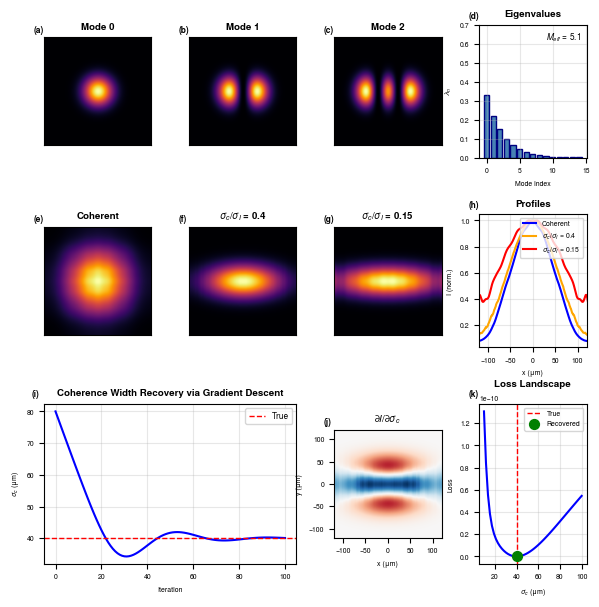

In [12]:
import string

fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.4, wspace=0.35,
                       height_ratios=[1, 1, 1.2])

subfig_idx = 0
def get_label():
    global subfig_idx
    label = f'({string.ascii_lowercase[subfig_idx]})'
    subfig_idx += 1
    return label

# Row 1: GSM modes (high coherence case)
ratio_demo = 0.4
sigma_c_demo = ratio_demo * beam_width
mode_set_demo = gaussian_schell_model_modes(
    wavelength=wavelength, dx=dx, grid_size=grid_size,
    beam_width=beam_width, coherence_width=sigma_c_demo, num_modes=num_modes
)

for col in range(3):
    ax = fig.add_subplot(gs[0, col])
    mode_intensity = jnp.abs(mode_set_demo.modes[col])**2
    ax.imshow(mode_intensity, cmap='inferno', extent=extent_um)
    ax.set_xlim(-120, 120)
    ax.set_ylim(-120, 120)
    ax.set_title(f'Mode {col}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold')

# Eigenvalue spectrum
ax = fig.add_subplot(gs[0, 3])
ax.bar(range(num_modes), mode_set_demo.weights, color='steelblue', edgecolor='navy')
ax.set_xlabel('Mode index')
ax.set_ylabel('$\\lambda_n$')
ax.set_title('Eigenvalues')
ax.set_ylim(0, 0.7)
ax.grid(True, alpha=0.3)
M_eff_demo = effective_mode_count(mode_set_demo)
ax.text(0.95, 0.95, f'$M_{{eff}}$ = {M_eff_demo:.1f}', transform=ax.transAxes,
        ha='right', va='top', fontsize=6)
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold')

# Row 2: Propagation comparison
prop_levels = [1.0, 0.4, 0.15]  # Fully coherent, partially, more partial

# Fully coherent
ax = fig.add_subplot(gs[1, 0])
I_coh_prop = jnp.abs(coherent_propagated.field)**2
ax.imshow(I_coh_prop, cmap='inferno', extent=extent_um)
ax.set_xlim(-120, 120)
ax.set_ylim(-120, 120)
ax.set_title('Coherent')
ax.set_xticks([])
ax.set_yticks([])
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold')

# Partially coherent cases
for idx, ratio in enumerate([0.4, 0.15]):
    ax = fig.add_subplot(gs[1, idx+1])
    sigma_c_prop = ratio * beam_width
    mode_set_prop = gaussian_schell_model_modes(
        wavelength=wavelength, dx=dx, grid_size=grid_size,
        beam_width=beam_width, coherence_width=sigma_c_prop, num_modes=10
    )
    mode_set_propagated = propagate_coherent_modes(mode_set_prop, prop_distance)
    I_prop = intensity_from_modes(mode_set_propagated)
    ax.imshow(I_prop, cmap='inferno', extent=extent_um)
    ax.set_xlim(-120, 120)
    ax.set_ylim(-120, 120)
    M_eff_prop = effective_mode_count(mode_set_prop)
    ax.set_title(f'$\\sigma_c/\\sigma_I$ = {ratio}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold')

# Profile comparison
ax = fig.add_subplot(gs[1, 3])
center = grid_size[0] // 2
x_um = (jnp.arange(grid_size[1]) - center) * dx * 1e6

ax.plot(x_um, I_coh_prop[center, :] / jnp.max(I_coh_prop), 'b-', 
        linewidth=1.5, label='Coherent')

for ratio, color in [(0.4, 'orange'), (0.15, 'red')]:
    sigma_c_prop = ratio * beam_width
    mode_set_prop = gaussian_schell_model_modes(
        wavelength=wavelength, dx=dx, grid_size=grid_size,
        beam_width=beam_width, coherence_width=sigma_c_prop, num_modes=10
    )
    mode_set_propagated = propagate_coherent_modes(mode_set_prop, prop_distance)
    I_prop = intensity_from_modes(mode_set_propagated)
    ax.plot(x_um, I_prop[center, :] / jnp.max(I_prop), color=color,
            linewidth=1.5, label=f'$\\sigma_c/\\sigma_I$ = {ratio}')

ax.set_xlabel('x (\u03bcm)')
ax.set_ylabel('I (norm.)')
ax.set_title('Profiles')
ax.set_xlim(-120, 120)
ax.legend(loc='upper right', fontsize=5)
ax.grid(True, alpha=0.3)
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold')

# Row 3: Optimization demo
# Coherence recovery
ax = fig.add_subplot(gs[2, 0:2])
ax.plot([w*1e6 for w in coherence_history], 'b-', linewidth=1.5)
ax.axhline(true_coherence_width*1e6, color='r', linestyle='--', linewidth=1, label='True')
ax.set_xlabel('Iteration')
ax.set_ylabel('$\\sigma_c$ (\u03bcm)')
ax.set_title('Coherence Width Recovery via Gradient Descent')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.text(-0.05, 1.05, get_label(), transform=ax.transAxes, fontweight='bold')

# Gradient map
ax = fig.add_subplot(gs[2, 2])
vmax_pub = jnp.max(jnp.abs(dI_dsigma))
ax.imshow(dI_dsigma, cmap='RdBu_r', extent=extent_um, vmin=-vmax_pub, vmax=vmax_pub)
ax.set_xlim(-120, 120)
ax.set_ylim(-120, 120)
ax.set_title('$\\partial I / \\partial \\sigma_c$')
ax.set_xlabel('x (\u03bcm)')
ax.set_ylabel('y (\u03bcm)')
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold')

# Loss landscape
ax = fig.add_subplot(gs[2, 3])
ax.plot(sigma_range*1e6, losses, 'b-', linewidth=1.5)
ax.axvline(true_coherence_width*1e6, color='r', linestyle='--', linewidth=1, label='True')
ax.scatter([params*1e6], [loss_fn(params)], c='green', s=50, zorder=5, label='Recovered')
ax.set_xlabel('$\\sigma_c$ (\u03bcm)')
ax.set_ylabel('Loss')
ax.set_title('Loss Landscape')
ax.legend(loc='upper right', fontsize=5)
ax.grid(True, alpha=0.3)
ax.text(-0.1, 1.05, get_label(), transform=ax.transAxes, fontweight='bold')

plt.savefig('Figures/coherence_publication_figure.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/coherence_publication_figure.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

---
## Summary

This tutorial demonstrated:

### Spatial Coherence
1. **Mutual intensity** $J(\mathbf{r}_1, \mathbf{r}_2)$ describes field correlations
2. **Van Cittert-Zernike theorem**: Extended sources create spatial coherence patterns
3. **Coherence kernels**: Gaussian and jinc (for circular sources)

### Temporal Coherence
1. **Spectral bandwidth** determines coherence length $L_c = \lambda^2/\Delta\lambda$
2. **Spectral shapes**: Gaussian, Lorentzian, blackbody distributions

### Coherent Mode Decomposition
1. **Mercer's theorem**: $J = \sum_n \lambda_n \phi_n^* \phi_n$
2. **Gaussian Schell-model**: Analytical Hermite-Gaussian modes
3. **Effective mode count**: Quantifies degree of partial coherence
4. **Efficient propagation** via `vmap` over modes

### Differentiability
1. **Gradient computation**: JAX enables $\partial I / \partial \sigma_c$ automatically
2. **Coherence recovery**: Gradient descent can recover source coherence from measurements
3. **Joint optimization**: Coherence parameters can be optimized alongside object/probe

### Key Functions

| Function | Description |
|----------|-------------|
| `gaussian_coherence_kernel()` | Gaussian spatial coherence |
| `jinc_coherence_kernel()` | Van Cittert-Zernike for circular source |
| `gaussian_schell_model_modes()` | GSM source modes |
| `propagate_coherent_modes()` | Propagate mode set |
| `intensity_from_modes()` | Incoherent intensity sum |
| `effective_mode_count()` | Participation ratio |